In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_heatmap = pd.read_csv('../datasets/A_data_heatmap_300x250_3p.csv')
data_metrics = pd.read_csv('../datasets/A_data_domain_perf_metrics_300x250_3p.csv')
data_heatmap_new1 = pd.read_csv('../datasets/A_data_heatmap_300x250_6p_h2m.csv')
data_heatmap_new2 = pd.read_csv('../datasets/A_data_heatmap_300x250_6p_t2m.csv')

In [3]:
data_metrics_6p = pd.read_csv('../datasets/A_data_domain_perf_metrics_300x250_6p.csv')

In [4]:
data_heatmap_6p = pd.concat([data_heatmap_new1,data_heatmap_new2],axis=0).drop(columns=['click_x_rel','click_y_rel'])

In [5]:
# data_heatmap_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)
# data_heatmap_expanded_new1 = data_heatmap_new1.loc[data_heatmap_new1.index.repeat(data_heatmap_new1['clicks'])].reset_index(drop=True)
# data_heatmap_expanded_new2 = data_heatmap_new2.loc[data_heatmap_new2.index.repeat(data_heatmap_new2['clicks'])].reset_index(drop=True)

# data_heatmap_expanded_6p = pd.concat([data_heatmap_expanded_new1,data_heatmap_expanded_new2],axis=0)
# data_heatmap_expanded_6p['clicks'] = 1

# click_stat = data_heatmap_expanded.groupby(['click_x','click_y'])['clicks'].count().reset_index()
# click_stat_new1 = data_heatmap_expanded_new1.groupby(['click_x','click_y'])['clicks'].count().reset_index()
# click_stat_new2 = data_heatmap_expanded_new2.groupby(['click_x','click_y'])['clicks'].count().reset_index()

# data_heatmap_expanded['clicks'] = 1
# data_heatmap_expanded_new1['clicks'] = 1
# data_heatmap_expanded_new2['clicks'] = 1

# Some Data wrangling

In [6]:
data_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)

max_width = data_expanded['display_width'].max()
max_height = data_expanded['display_height'].max()

width_bins = np.linspace(1, max_width, 61)
height_bins = np.linspace(1, max_height, 51)

data_expanded['click_x_bin'] = pd.cut(data_expanded['click_x'], 
                                      bins = width_bins, 
                                      labels=False, 
                                      include_lowest=True)

data_expanded['click_y_bin'] = pd.cut(data_expanded['click_y'], 
                                      bins=height_bins, 
                                      labels=False, 
                                      include_lowest=True)


aggregated_clicks = data_expanded.groupby(['grid_id',
                                           'domain', 
                                           'click_x_bin', 
                                           'click_y_bin']).size().reset_index(name='clicks_sum')

# cl_stat = aggregated_clicks.groupby(['click_x_bin','click_y_bin']).count().reset_index()
# cl_stat = cl_stat[['click_x_bin','click_y_bin','clicks_sum']]
# cl_stat['bin_prob'] = cl_stat['clicks_sum']/cl_stat['clicks_sum'].sum()

aggregated_clicks_by_grid = aggregated_clicks.groupby([
                                'grid_id','click_x_bin','click_y_bin'
                            ]).sum('clicks_sum').reset_index()

In [7]:
data_expanded_6p = data_heatmap_6p.loc[data_heatmap_6p.index.repeat(data_heatmap_6p['clicks'])].reset_index(drop=True)

max_width = data_expanded_6p['display_width'].max()
max_height = data_expanded_6p['display_height'].max()

width_bins = np.linspace(1, max_width, 61)
height_bins = np.linspace(1, max_height, 51)

data_expanded_6p['click_x_bin'] = pd.cut(data_expanded_6p['click_x'], 
                                      bins = width_bins, 
                                      labels=False, 
                                      include_lowest=True)

data_expanded_6p['click_y_bin'] = pd.cut(data_expanded_6p['click_y'], 
                                      bins=height_bins, 
                                      labels=False, 
                                      include_lowest=True)


aggregated_clicks_6p = data_expanded_6p.groupby(['grid_id',
                                           'domain', 
                                           'click_x_bin', 
                                           'click_y_bin']).size().reset_index(name='clicks_sum')


aggregated_clicks_by_grid_6p = aggregated_clicks_6p.groupby([
                                'grid_id','click_x_bin','click_y_bin'
                            ]).sum('clicks_sum').reset_index()

# Basic Bootstrap approach

In [8]:
def weighted_bootstrap_resample(data, drawing_distro, emp_distro, size, n_bootstraps=1000):
    tot_log_proba = 0
    
    # resample heatmap of size = size n_bootstrap times
    for _ in range(n_bootstraps):
        # draw samples from drawing_distro column:
        indices = np.random.choice(data.index, 
                                   size=size, 
                                   replace=True, 
                                   p=data[drawing_distro])
        
        # compute log-probability for current sample based on emp_distro column:
        log_proba = np.log(data.loc[indices][emp_distro]).sum()
        
        # cumulative log-probability
        tot_log_proba += log_proba
        
    # compute and return average log-probability:
    return tot_log_proba/n_bootstraps

In [9]:
def weighted_jittered_bootstrap_resample(data, drawing_distro, total_data_size, stdev=2):
    tot_log_proba = 0
    pert_x = np.random.normal(0, stdev, total_data_size).round().astype(int)
    pert_y = np.random.normal(0, stdev, total_data_size).round().astype(int)
    indices = np.random.choice(data.index, 
                               total_data_size, 
                               replace=True, 
                               p=data[drawing_distro])
    
    log_proba = np.log(data.loc[indices][emp_distro]).sum()
    tot_log_proba += log_proba
    return tot_log_proba/n_bootstraps #boots[['click_x_bin','click_y_bin', 'boot']]

# Basic Chi-squared test

In [10]:
from scipy.stats import chisquare

def Chi_squared_test(aggregated_clicks, aggregated_clicks_by_grid, ID, GRID_ID):
    observed = aggregated_clicks[(aggregated_clicks.grid_id == GRID_ID) &
                                 (aggregated_clicks.domain == ID)]

    click_stat_grid = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == GRID_ID]
    click_stat_grid = click_stat_grid.copy()
    click_stat_grid['bin_prob'] = click_stat_grid['clicks_sum']/click_stat_grid['clicks_sum'].sum()

    observed_freq = observed.merge(click_stat_grid, 
                                   on=['click_x_bin',
                                       'click_y_bin'], 
                                   how='right').fillna(0)

    observed_freq = observed[['click_x_bin',
                              'click_y_bin',
                              'clicks_sum']].merge(click_stat_grid[['click_x_bin',
                                                    'click_y_bin',
                                                    'bin_prob']], 
                                   on=['click_x_bin',
                                       'click_y_bin'], 
                                   how='right').fillna(0)

    total_observations = observed_freq['clicks_sum'].sum()
    observed_freq['Expected'] = observed_freq['bin_prob'] * total_observations

    # Perform Chi-square test
    chi_square_stat, p_value = chisquare(f_obs = observed_freq['clicks_sum'], 
                                         f_exp = observed_freq['Expected'])
    
    return chi_square_stat, p_value, total_observations

# Data enhancement

In [11]:
from itertools import product

def enhance_data(data, prob, size, sdev):
    indices = np.random.choice(data.index, 
                                   size, 
                                   replace=True, 
                                   p = data[prob])
    
    pert_x = np.random.normal(0, sdev, size).round().astype(int)
    pert_y = np.random.normal(0, sdev, size).round().astype(int)

    x = data.loc[indices][['click_x_bin', 'click_y_bin']] + np.array((pert_x, pert_y)).reshape(-1,2)
    x_bin_max = data['click_x_bin'].max()
    y_bin_max = data['click_y_bin'].max()
    
    x[x['click_x_bin'] < 0]['click_x_bin'] = 0
    x[x['click_y_bin'] < 0]['click_y_bin'] = 0
    x[x['click_x_bin'] > x_bin_max]['click_x_bin'] = x_bin_max
    x[x['click_y_bin'] > y_bin_max]['click_y_bin'] = y_bin_max
    
    x = x.groupby(['click_x_bin','click_y_bin']).size().reset_index(name = 'clicks_sum')

    tt = pd.DataFrame(list(product(range(0,x_bin_max+1), range(0,y_bin_max+1))), 
                      columns=['click_x_bin', 'click_y_bin'])

    data_obs_merged = tt.merge(x, on = ['click_x_bin','click_y_bin'], how = 'left').fillna(0)
#    data_obs_merged['boots_clicks'].sum()
    return data_obs_merged

# Chi-squared test with bootstrapped enhancement:

In [12]:
def Chi_squared_test_enh(aggregated_clicks, aggregated_clicks_by_grid, ID, GRID_ID, samp_size, stdev):
    
    # observed heatmap domain = ID and grid_id = GRID_ID:
    observed = aggregated_clicks[(aggregated_clicks.grid_id == GRID_ID) &
                                 (aggregated_clicks.domain == ID)]
    
    observed['proba'] = observed['clicks_sum']/observed['clicks_sum'].sum()
    
    # bootstrap enhance data to samp_size with stdev:
    observed = enhance_data(observed, 'proba', samp_size, stdev)
    
    # empirical distribution + probabilities for grid_id=GRID_ID
    click_stat_grid = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == GRID_ID]
    click_stat_grid = click_stat_grid.copy()
    click_stat_grid['bin_prob'] = click_stat_grid['clicks_sum']/click_stat_grid['clicks_sum'].sum()

    observed_freq = observed.merge(click_stat_grid, 
                                   on=['click_x_bin',
                                       'click_y_bin'], 
                                   how='right').fillna(0)

    observed_freq = observed[['click_x_bin',
                              'click_y_bin',
                              'clicks_sum']].merge(click_stat_grid[['click_x_bin',
                                                    'click_y_bin',
                                                    'bin_prob']], 
                                                   on=['click_x_bin',
                                                       'click_y_bin'], 
                                                   how='right').fillna(0)

    total_observations = observed_freq['clicks_sum'].sum()
    observed_freq['Expected'] = observed_freq['bin_prob'] * total_observations

    chi_square_stat, p_value = chisquare(f_obs = observed_freq['clicks_sum'], 
                                         f_exp = observed_freq['Expected'])
    
    return chi_square_stat, p_value, total_observations

In [13]:
# save domains by grid id:
domains_by_grid_id = pd.DataFrame(aggregated_clicks.groupby('grid_id')['domain'].unique()).reset_index()

In [14]:
data_bad = pd.DataFrame(list(product(range(0,60),range(0,50))), 
                                          columns=['click_x_bin', 'click_y_bin'])
data_bad['proba'] = 1/data_bad.shape[0]

In [15]:
# len(cb_333519+cb_333346+cb_333346_6p+cb_333519_6p)

In [16]:
cb_333519 = ['ID_1184', 'ID_1281', 'ID_1305', 'ID_1353', 'ID_1448', 'ID_1522',
       'ID_1544', 'ID_162', 'ID_1682', 'ID_1690', 'ID_1824', 'ID_1888',
       'ID_1929', 'ID_2076', 'ID_2097', 'ID_2226', 'ID_2249', 'ID_2268',
       'ID_2331', 'ID_2339', 'ID_2386', 'ID_2396', 'ID_2438', 'ID_258',
       'ID_2609', 'ID_2680', 'ID_2863', 'ID_2883', 'ID_2908', 'ID_3061',
       'ID_3243', 'ID_3250', 'ID_3314', 'ID_3382', 'ID_3397', 'ID_3402',
       'ID_3420', 'ID_3459', 'ID_3470', 'ID_3540', 'ID_398', 'ID_409',
       'ID_484', 'ID_489', 'ID_526', 'ID_549', 'ID_580', 'ID_665',
       'ID_810', 'ID_84', 'ID_857', 'ID_86', 'ID_905', 'ID_927', 'ID_934',
       'ID_962', 'ID_986']

cb_333346 = ['ID_1247', 'ID_162', 'ID_2534', 'ID_2742', 'ID_526', 'ID_2201',
       'ID_1165', 'ID_743', 'ID_199', 'ID_2145', 'ID_2569', 'ID_643',
       'ID_1305', 'ID_3180', 'ID_3158', 'ID_136', 'ID_293', 'ID_1753',
       'ID_1849', 'ID_2226', 'ID_1462', 'ID_626', 'ID_2863', 'ID_3243',
       'ID_3250', 'ID_1708', 'ID_1238', 'ID_580', 'ID_84', 'ID_2568',
       'ID_2340', 'ID_1803', 'ID_3470', 'ID_139', 'ID_2619', 'ID_2908',
       'ID_1281', 'ID_3308', 'ID_2883', 'ID_1320', 'ID_1333', 'ID_1062',
       'ID_149', 'ID_260', 'ID_599', 'ID_1513', 'ID_3402', 'ID_1888',
       'ID_2972', 'ID_398', 'ID_2339', 'ID_1030', 'ID_3382', 'ID_2076',
       'ID_1646', 'ID_1077', 'ID_10', 'ID_1153', 'ID_1533', 'ID_2609',
       'ID_1214', 'ID_810', 'ID_2097', 'ID_2386', 'ID_1585', 'ID_549',
       'ID_3420', 'ID_3397', 'ID_2006', 'ID_561', 'ID_1542', 'ID_1570',
       'ID_1819', 'ID_1413', 'ID_1240', 'ID_793', 'ID_831', 'ID_3188',
       'ID_1437', 'ID_556', 'ID_1134', 'ID_314', 'ID_2836', 'ID_1483',
       'ID_2676', 'ID_665', 'ID_15', 'ID_2755', 'ID_2194', 'ID_1682',
       'ID_2775', 'ID_1923', 'ID_1846', 'ID_1262', 'ID_3314', 'ID_1448',
       'ID_1770', 'ID_2626', 'ID_3296', 'ID_489', 'ID_1963', 'ID_1268',
       'ID_1568', 'ID_1094', 'ID_2267', 'ID_409', 'ID_1650', 'ID_1522',
       'ID_927', 'ID_2302', 'ID_1929', 'ID_1435', 'ID_1353']

cb_333346_6p = ['ID_106', 'ID_1108', 'ID_1111', 'ID_1150', 'ID_1217', 'ID_136', 
             'ID_1542', 'ID_1589', 'ID_1602', 'ID_185', 'ID_1908', 'ID_1915', 
             'ID_1916', 'ID_1971',  'ID_2015', 'ID_2063', 'ID_2133', 'ID_2143', 
             'ID_2336', 'ID_2337', 'ID_2368', 'ID_243', 'ID_245', 'ID_2553', 
             'ID_2564', 'ID_2635', 'ID_2636', 'ID_267', 'ID_2693', 'ID_27', 
             'ID_2737', 'ID_2750', 'ID_2762', 'ID_2867', 'ID_2924', 'ID_2933', 
             'ID_2977', 'ID_3172', 'ID_3219', 'ID_324', 'ID_3268', 'ID_333', 
             'ID_3334', 'ID_3487', 'ID_3526', 'ID_3535', 'ID_3567', 'ID_3605', 
             'ID_362', 'ID_3633', 'ID_3640', 'ID_365', 'ID_367', 'ID_3672', 
             'ID_3699', 'ID_3730', 'ID_3809', 'ID_3837', 'ID_3848', 'ID_3920', 
             'ID_3939', 'ID_3982', 'ID_401', 'ID_4042', 'ID_4058', 'ID_4072', 
             'ID_4076', 'ID_4199', 'ID_4206', 'ID_4224', 'ID_4378', 'ID_4507', 
             'ID_466', 'ID_494', 'ID_539', 'ID_62', 'ID_727', 'ID_737', 
             'ID_861', 'ID_876', 'ID_889', 'ID_90', 'ID_922', 'ID_949', 
             'ID_981', 'ID_993']

cb_333519_6p = ['ID_1081', 'ID_1150', 'ID_1464', 'ID_1518', 'ID_1622', 'ID_1623', 
                'ID_1624', 'ID_1631', 'ID_1678', 'ID_1623', 'ID_1731', 'ID_1752', 
                'ID_1764', 'ID_1795', 'ID_1915', 'ID_1916', 'ID_1971', 'ID_198', 
                'ID_2018', 'ID_204', 'ID_2044', 'ID_2104', 'ID_2108', 'ID_2109', 
                'ID_2146', 'ID_2251', 'ID_2330', 'ID_2336', 'ID_2381', 'ID_2383', 
                'ID_2400', 'ID_2616', 'ID_2636', 'ID_2749', 'ID_2766', 'ID_2779', 
                'ID_2809', 'ID_284', 'ID_2875', 'ID_2881', 'ID_30', 'ID_3021', 
                'ID_3049', 'ID_3098', 'ID_3178', 'ID_3183', 'ID_3219', 'ID_3232', 
                'ID_3561', 'ID_3644', 'ID_365', 'ID_3850', 'ID_389', 'ID_4025', 
                'ID_4036', 'ID_4050', 'ID_4058', 'ID_4075', 'ID_4113', 'ID_4122', 
                'ID_4255', 'ID_4257', 'ID_4275', 'ID_4347', 'ID_44', 'ID_4506', 
                'ID_4567', 'ID_618', 'ID_727', 'ID_737', 'ID_922', 'ID_950', 
                'ID_960', 'ID_969']

cb_333346_6p = ['ID_106', 'ID_1003', 'ID_1081', 'ID_1108', 'ID_1111', 'ID_1150', 'ID_1217', 'ID_1303', 'ID_1347', 
                'ID_136', 'ID_1464', 'ID_1542', 'ID_1579', 'ID_1589', 'ID_1602', 'ID_1624','ID_1640', 'ID_1731',
                'ID_185', 'ID_1902', 'ID_1908', 'ID_1915', 'ID_1916', 'ID_1917','ID_1971', 'ID_1974', 'ID_2015', 
                'ID_2063', 'ID_2077', 'ID_2099', 'ID_2104', 'ID_2108', 'ID_2133', 'ID_2143', 'ID_2214', 'ID_2242',
                'ID_2279', 'ID_2336', 'ID_2337', 'ID_2368', 'ID_2400', 'ID_2404', 'ID_243', 'ID_2435', 'ID_245', 
                'ID_2553', 'ID_2564', 'ID_2598', 'ID_2626', 'ID_2627', 'ID_2635', 'ID_2636', 'ID_2648', 'ID_267', 
                'ID_2693', 'ID_27', 'ID_2737', 'ID_2750', 'ID_2760', 'ID_2762', 'ID_2766', 'ID_2779', 'ID_2809', 
                'ID_2867', 'ID_2881', 'ID_2924', 'ID_2933', 'ID_2977', 'ID_3019', 'ID_3098', 'ID_313', 'ID_3157', 
                'ID_3172', 'ID_3178', 'ID_3219', 'ID_3231', 'ID_324', 'ID_3268', 'ID_3308', 'ID_333', 'ID_3334', 
                'ID_3375', 'ID_3389', 'ID_3405', 'ID_3418', 'ID_3472', 'ID_3487', 'ID_3526', 'ID_3535', 'ID_3567',
                'ID_3605', 'ID_3614', 'ID_362', 'ID_3633', 'ID_3640', 'ID_3644', 'ID_365', 'ID_367', 'ID_3672', 
                'ID_3699', 'ID_3726', 'ID_3730', 'ID_3781', 'ID_3799', 'ID_3800', 'ID_3809', 'ID_3837', 'ID_3848', 
                'ID_3850', 'ID_389', 'ID_3917', 'ID_3920', 'ID_3939', 'ID_3982', 'ID_401', 'ID_4016', 'ID_4040',
                'ID_4042', 'ID_4058', 'ID_4072', 'ID_4076', 'ID_4199', 'ID_4204', 'ID_4206', 'ID_4224', 'ID_4275',
                'ID_429', 'ID_4347', 'ID_4378', 'ID_4507', 'ID_4567','ID_466', 'ID_494', 'ID_514', 'ID_539', 
                'ID_582', 'ID_62', 'ID_71', 'ID_727', 'ID_731', 'ID_737', 'ID_825', 'ID_861', 'ID_869', 'ID_876', 
                'ID_889', 'ID_90', 'ID_922', 'ID_949', 'ID_969', 'ID_979', 'ID_981', 'ID_993']

In [17]:
cb = {333519: cb_333519, 333346: cb_333346}
cb_6p = {333519: cb_333519_6p, 333346: cb_333346_6p}

# Emp distro = cumulative

In [18]:
aggregated_clicks_by_grid.groupby(['click_x_bin','click_y_bin'])

In [19]:
# # old
# # upsampling size:
# size = 1000

# # stdev for noisy bootstrap enhancement:
# stdev = 0

# # init to count pct of broken banners:
# tot_p, tot, tot_pv, tot_lrt = 0, 0, 0, 0

# # keep track of misidentified:
# misid = {}

# # p-value threshold for chi-squared test:
# pv_thresh = 0.0000001

# # probability threshold:
# # proba_thres = 0.0000001

# for proba_thres in [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]:
    
#     misid[proba_thres] = {'FN': [], 'FP': []}
#     TP, TN, FP, FN = 0, 0, 0, 0
    
#     for g_id in [333519, 333346]: 

#         # data = all clicks for grid_id = g_id (in principle should probably do some train/test split):
#         data = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == g_id]

#         # compute probability by bin
#         data['proba'] = data['clicks_sum']/data['clicks_sum'].sum()

#         '''
#         compute probability for "average" heatmap based on bootstrap sampling of data. 

#         The empirical distribution is given by the proba columns and we bootstrap
#         sample based on that column as well as evaluate the log-probability.

#         The bootstrapped sample is of size = size (notice that the size should be 
#         the same as the size for the instance-heatmap to get "fair" comparison, if not
#         we would have to normalize accordingly).

#         n_bootstrap = number of generated heatmaps to compute average.

#         The following returns the avg log-probability:
#         '''
#         avg_from_empirical = weighted_bootstrap_resample(data, 
#                                                          'proba', 
#                                                          'proba', 
#                                                          size, 
#                                                          n_bootstraps=1000)

#         avg_from_empirical_bad = weighted_bootstrap_resample(data_bad, 
#                                                          'proba', 
#                                                          'proba', 
#                                                          size, 
#                                                          n_bootstraps=1000)


#         # run over domains, dom for given grid_id = g_id:
#         for dom in domains_by_grid_id[domains_by_grid_id.grid_id == g_id]['domain'].iloc[0]:
#             tot += 1

#             ####################
#             # chi-squared method:
#             # returns p-value for chi-squared comparison of heatmap vs empirical distribution
#             _, pv, tot_obs = Chi_squared_test_enh(aggregated_clicks, 
#                                                   aggregated_clicks_by_grid, 
#                                                   dom, g_id, size, .5)

#             ####################
#             # log-probability method:

#             # data_obs = "observed" heatmap for current domain_id = dom
#             data_obs = aggregated_clicks[(aggregated_clicks.grid_id == g_id) &
#                                          (aggregated_clicks.domain == dom)]

#             # add proba column in order to do bootstrap enhancement:
#             data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()

#             # enhanced observed heatmap of size = size, with stdev = stdev 
#             # and sampling based on proba column:
#             data_obs_enh = a

#             # merge enhanced observed heatmap with empirical distribution
#             # in order to get empircal probabilities for bins:
#             data_obs = data_obs_enh.merge(data, 
#                                           on=['click_x_bin','click_y_bin'], 
#                                           how='right').fillna(0)

#             # log-probablity for enhanced oberved heatmap given the underlying empirical distribution:
#             from_obs = (np.log(data_obs['proba'])*data_obs['clicks_sum_x']).sum()

#             # compare with average heatmap from empirical distribution:
#             # prob = P[distr for domain]/P[avg distr]
#             prob = np.exp(from_obs - avg_from_empirical)
#             log_prob = from_obs - avg_from_empirical

#             # if log_prob below certain threshold, label as broken:

#             if log_prob < np.log(proba_thres):
#                 tot_p +=1

#             # compare both log-prob and chi-squared p-value:
#             if log_prob < np.log(proba_thres) and pv < pv_thresh:
#                 tot_pv += 1

#             ####################
#             # "lrt" method:

#             data_obs_bad = data_obs_enh.merge(data_bad, 
#                                           on=['click_x_bin','click_y_bin'], 
#                                           how='right').fillna(0)

#             from_obs_bad = (np.log(data_obs_bad['proba'])*data_obs_bad['clicks_sum_x']).sum()

#             loglrt = from_obs - from_obs_bad

#             if loglrt < np.log(proba_thres):
#                 tot_lrt += 1
#                 if dom in cb[g_id]:
#                     TP += 1
#                 else:
#                     FP += 1
#                     misid[proba_thres]['FP'].append(dom)
#             else:
#                 if dom in cb[g_id]:
#                     FN += 1
#                     misid[proba_thres]['FN'].append(dom)
#                 else:
#                     TN += 1

#     print(f'Probability thresh: {proba_thres}')
#     print(f'Confusion matrix: ((TN,FN),(FP,TP)) = ({TN},{FN}),({FP},{TP})')
#     print('-----------------------------------------------------------')
            

In [20]:
# TN,FN,FP,TP = 1557,59,6,111

# prec = TP/(TP+FP)
# recall = TP/(TP+FN)
# F1 = 2*prec*recall/(prec+recall)

# print(prec,recall,F1)

In [21]:
# unique_gd_comb = data_heatmap.groupby(['grid_id','domain']).size().reset_index(name='Freq')[['grid_id','domain']]

In [22]:
# cb_333346 = cb_333346+['ID_2274','ID_2198','ID_962', 'ID_657']

In [23]:
# for dom in misid[1e-06]['FP']:
#     if dom in unique_gd_comb[unique_gd_comb.grid_id == 333346].domain.unique():
#         print('aasdfasdfasdfasdf')
#         data_obs = aggregated_clicks[(aggregated_clicks.grid_id == 333346) &
#                                      (aggregated_clicks.domain == dom)]
#         data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
#         data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
#         click_matrix = data_obs_enh.pivot("click_y_bin",
#                                           "click_x_bin",
#                                           "clicks_sum").fillna(0)
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(click_matrix, 
#                     cmap = "YlGnBu", 
#                     annot = False, 
#                     cbar = True, 
#                     fmt = "g")
#         plt.title(f'Click Heatmap for id = {dom} and grid = {333346}')
#         plt.xlabel('click_x Bin')
#         plt.ylabel('click_y Bin')
#         plt.gca().invert_yaxis() 
#         plt.show()
#     elif  dom in unique_gd_comb[unique_gd_comb.grid_id == 333519].domain.unique():

#         data_obs = aggregated_clicks[(aggregated_clicks.grid_id == 333519) &
#                                      (aggregated_clicks.domain == dom)]
#         data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
#         data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
#         click_matrix = data_obs_enh.pivot("click_y_bin",
#                                           "click_x_bin",
#                                           "clicks_sum").fillna(0)
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(click_matrix, 
#                     cmap = "YlGnBu", 
#                     annot = False, 
#                     cbar = True, 
#                     fmt = "g")
#         plt.title(f'Click Heatmap for id = {dom} and grid = {333519}')
#         plt.xlabel('click_x Bin')
#         plt.ylabel('click_y Bin')
#         plt.gca().invert_yaxis() 
#         plt.show()
        

## True Positives:

### 333519

In [24]:
# for dom in cb[333519]:
#     if dom not in misid[1e-06]['FN']:
#         data_obs = aggregated_clicks[(aggregated_clicks.grid_id == 333519) &
#                                      (aggregated_clicks.domain == dom)]
#         print(f'Total clicks for (grid_id, domain): (333519, {dom}): {data_obs.clicks_sum.sum()}')
#         data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
#         data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
#         click_matrix = data_obs_enh.pivot("click_y_bin",
#                                           "click_x_bin",
#                                           "clicks_sum").fillna(0)
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(click_matrix, 
#                     cmap = "YlGnBu", 
#                     annot = False, 
#                     cbar = True, 
#                     fmt = "g")
#         plt.title(f'Click Heatmap for id = {dom} and grid = {333519}')
#         plt.xlabel('click_x Bin')
#         plt.ylabel('click_y Bin')
#         plt.gca().invert_yaxis() 
#         plt.show()
        

### 333346

In [25]:
# for dom in cb[333346]:
#     if dom not in misid[1e-06]['FN']:
#         data_obs = aggregated_clicks[(aggregated_clicks.grid_id == 333346) &
#                                      (aggregated_clicks.domain == dom)]
#         data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
#         data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
#         click_matrix = data_obs_enh.pivot("click_y_bin",
#                                           "click_x_bin",
#                                           "clicks_sum").fillna(0)
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(click_matrix, 
#                     cmap = "YlGnBu", 
#                     annot = False, 
#                     cbar = True, 
#                     fmt = "g")
#         plt.title(f'Click Heatmap for id = {dom} and grid = {333346}')
#         plt.xlabel('click_x Bin')
#         plt.ylabel('click_y Bin')
#         plt.gca().invert_yaxis() 
#         plt.show()

## False Negative

In [26]:
# for dom in misid[1e-06]['FN']:
#     if dom in unique_gd_comb[unique_gd_comb.grid_id == 333346].domain.unique():

#         data_obs = aggregated_clicks[(aggregated_clicks.grid_id == 333346) &
#                                      (aggregated_clicks.domain == dom)]
        
#         print(f'Total clicks for (grid_id, domain): (333346, {dom}): {data_obs.clicks_sum.sum()}')
#         data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
#         data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
#         click_matrix = data_obs_enh.pivot("click_y_bin",
#                                           "click_x_bin",
#                                           "clicks_sum").fillna(0)
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(click_matrix, 
#                     cmap = "YlGnBu", 
#                     annot = False, 
#                     cbar = True, 
#                     fmt = "g")
#         plt.title(f'Click Heatmap for id = {dom} and grid = {333346}')
#         plt.xlabel('click_x Bin')
#         plt.ylabel('click_y Bin')
#         plt.gca().invert_yaxis() 
#         plt.show()
#     elif  dom in unique_gd_comb[unique_gd_comb.grid_id == 333519].domain.unique():
#         data_obs = aggregated_clicks[(aggregated_clicks.grid_id == 333519) &
#                                      (aggregated_clicks.domain == dom)]
#         print(f'Total clicks for (grid_id, domain): (333519, {dom}): {data_obs.clicks_sum.sum()}')
#         data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
#         data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
#         click_matrix = data_obs_enh.pivot("click_y_bin",
#                                           "click_x_bin",
#                                           "clicks_sum").fillna(0)
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(click_matrix, 
#                     cmap = "YlGnBu", 
#                     annot = False, 
#                     cbar = True, 
#                     fmt = "g")
#         plt.title(f'Click Heatmap for id = {dom} and grid = {333519}')
#         plt.xlabel('click_x Bin')
#         plt.ylabel('click_y Bin')
#         plt.gca().invert_yaxis() 
#         plt.show()

# Emp distro = representative

In [27]:
# # pick most clicks and highest landing rate:

# representative_heatmap = {}

# for g_id in [333519, 333346]:
#     filtered_data = data_metrics[data_metrics.grid_id == g_id]

#     result = filtered_data[(filtered_data.landed_clicks / filtered_data.clicks) > 0.8]
#     dom = result.sort_values(by='clicks', ascending=False).iloc[0].domain
#     representative_heatmap[g_id] = dom
    
#     data_obs = aggregated_clicks[(aggregated_clicks.grid_id == g_id) &
#                                  (aggregated_clicks.domain == dom)]
#     print(f'Total clicks for (grid_id, domain): (333519, {dom}): {data_obs.clicks_sum.sum()}')
#     data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
#     data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
#     click_matrix = data_obs_enh.pivot("click_y_bin",
#                                       "click_x_bin",
#                                       "clicks_sum").fillna(0)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(click_matrix, 
#                 cmap = "YlGnBu", 
#                 annot = False, 
#                 cbar = True, 
#                 fmt = "g")
#     plt.title(f'Click Heatmap for id = {dom} and grid = {333519}')
#     plt.xlabel('click_x Bin')
#     plt.ylabel('click_y Bin')
#     plt.gca().invert_yaxis() 
#     plt.show()

# Run gridsearch for LRT:

In [28]:
# # upsampling size:
# # size = 1000

# # avoid dividing by 0:
# eps = 1e-20

# # keep track of misidentified:
# misid = {}
# misid1 = {}

# # p-value threshold for chi-squared test:
# pv_thresh = 0.0000001

# # probability threshold:
# # proba_thres = 0.0000001

# for stdev in [0, 1, 2]:
#     for size in [1000, 5000, 10000]:
#         for proba_thres in [0.1, 0.001, 0.00001, 0.0000001]:

#             misid[(stdev,size,proba_thres)] = {'FN': [], 'FP': []}
#             TP, TN, FP, FN = 0, 0, 0, 0
            
#             misid1[(stdev,size,proba_thres)] = {'FN': [], 'FP': []}
#             TP1, TN1, FP1, FN1 = 0, 0, 0, 0

#             for g_id in [333519, 333346]: 

#                 # data = repr clicks for grid_id = g_id (in principle should probably do some train/test split):
#                 data = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == g_id]

#                 # compute probability by bin
#                 # data['proba'] = data['clicks_sum']/data['clicks_sum'].sum()

#                 data = pd.DataFrame(list(product(range(0,60),range(0,50))), 
#                                           columns=['click_x_bin', 'click_y_bin'])
                
#                 # representative probabilities:
#                 data_obs_rep = aggregated_clicks[(aggregated_clicks.grid_id == g_id) &
#                                                  (aggregated_clicks.domain == representative_heatmap[g_id])]

#                 # merge enhanced observed heatmap with empirical distribution
#                 # in order to get empircal probabilities for bins:
#                 data_obs_rep = data_obs_rep.merge(data, 
#                                               on=['click_x_bin','click_y_bin'], 
#                                               how='right').fillna(0)
                
#                 data_obs_rep['proba'] = data_obs_rep.clicks_sum/data_obs_rep.clicks_sum.sum()

#                 data = data.merge(data_obs_rep[['click_x_bin','click_y_bin','proba']], 
#                                   on = ['click_x_bin','click_y_bin'], 
#                                   how='left' )
                
#                 data = data.fillna(0)

#                 '''
#                 compute probability for "average" heatmap based on bootstrap sampling of data. 

#                 The empirical distribution is given by the proba columns and we bootstrap
#                 sample based on that column as well as evaluate the log-probability.

#                 The bootstrapped sample is of size = size (notice that the size should be 
#                 the same as the size for the instance-heatmap to get "fair" comparison, if not
#                 we would have to normalize accordingly).

#                 n_bootstrap = number of generated heatmaps to compute average.

#                 The following returns the avg log-probability:
#                 '''
#                 avg_from_empirical = weighted_bootstrap_resample(data, 
#                                                                  'proba', 
#                                                                  'proba', 
#                                                                  size, 
#                                                                  n_bootstraps=1000)

#                 avg_from_empirical_bad = weighted_bootstrap_resample(data_bad, 
#                                                                  'proba', 
#                                                                  'proba', 
#                                                                  size, 
#                                                                  n_bootstraps=1000)


#                 # run over domains, dom for given grid_id = g_id:
#                 for dom in domains_by_grid_id[domains_by_grid_id.grid_id == g_id]['domain'].iloc[0]:
#                     tot += 1

#                     ####################
#                     # chi-squared method:
#                     # returns p-value for chi-squared comparison of heatmap vs empirical distribution
# #                     _, pv, tot_obs = Chi_squared_test_enh(aggregated_clicks, 
# #                                                           aggregated_clicks_by_grid, 
# #                                                           dom, g_id, size, .5)

#                     ####################
#                     # log-probability method:

#                     # data_obs = "observed" heatmap for current domain_id = dom
#                     data_obs = aggregated_clicks[(aggregated_clicks.grid_id == g_id) &
#                                                  (aggregated_clicks.domain == dom)]

#                     # add proba column in order to do bootstrap enhancement:
#                     data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()

#                     # enhanced observed heatmap of size = size, with stdev = stdev 
#                     # and sampling based on proba column:
#                     data_obs_enh = enhance_data(data_obs, 'proba', size, stdev)

#                     # merge enhanced observed heatmap with empirical distribution
#                     # in order to get empircal probabilities for bins:
#                     data_obs = data_obs_enh.merge(data, 
#                                                   on=['click_x_bin','click_y_bin'], 
#                                                   how='right').fillna(0)

#                     # log-probablity for enhanced oberved heatmap given the underlying empirical distribution:
#                     from_obs = (np.log(data_obs['proba']+eps)*data_obs['clicks_sum']).sum()

#                     # compare with average heatmap from empirical distribution:
#                     # prob = P[distr for domain]/P[avg distr]
#                     prob = np.exp(from_obs - avg_from_empirical)
#                     log_prob = from_obs - avg_from_empirical

#                     # if log_prob below certain threshold, label as broken:

#                     if log_prob < np.log(proba_thres):
#                         tot_p +=1

#                     # compare both log-prob and chi-squared p-value:
#                     if log_prob < np.log(proba_thres) and pv < pv_thresh:
#                         tot_pv += 1

#                     ####################
#                     # "lrt" method:

#                     data_obs_bad = data_obs_enh.merge(data_bad, 
#                                                   on=['click_x_bin','click_y_bin'], 
#                                                   how='right').fillna(0)

#                     from_obs_bad = (np.log(data_obs_bad['proba']+eps)*data_obs_bad['clicks_sum']).sum()

#                     loglrt = from_obs - from_obs_bad

#                     if loglrt < np.log(proba_thres):
#                         tot_lrt += 1
#                         if dom in cb[g_id]:
#                             TP += 1
#                         else:
#                             FP += 1
#                             misid[(stdev,size,proba_thres)]['FP'].append(dom)
#                     else:
#                         if dom in cb[g_id]:
#                             FN += 1
#                             misid[(stdev,size,proba_thres)]['FN'].append(dom)
#                         else:
#                             TN += 1
                            
                            
#                     if log_prob < np.log(proba_thres):
#                         tot_lrt += 1
#                         if dom in cb[g_id]:
#                             TP1 += 1
#                         else:
#                             FP1 += 1
#                             misid1[(stdev,size,proba_thres)]['FP'].append(dom)
#                     else:
#                         if dom in cb[g_id]:
#                             FN1 += 1
#                             misid1[(stdev,size,proba_thres)]['FN'].append(dom)
#                         else:
#                             TN1 += 1

#             print(f'Standard dev: {stdev}')
#             print(f'Upsample size: {size}')
#             print(f'Probability thresh: {proba_thres}')
#             print(f'Confusion matrix (lrt): ((TN,FN),(FP,TP)) = ({TN},{FN}),({FP},{TP})')
#             if TP+FP != 0 and TP+FN !=0:
#                 prec = TP/(TP+FP)
#                 recall = TP/(TP+FN)
#                 F1 = 2*prec*recall/(prec+recall)
#                 print(f'F1-score: {F1:.5f}')
#             print(f'Confusion matrix (old): ((TN,FN),(FP,TP)) = ({TN1},{FN1}),({FP1},{TP1})')
#             print('-----------------------------------------------------------')
            

## New data:

Total clicks for (grid_id, domain): (333519, ID_3516): 482667


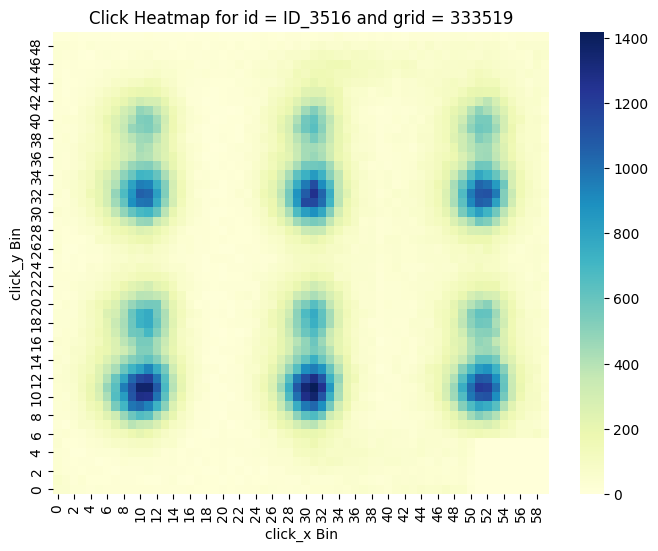

Total clicks for (grid_id, domain): (333346, ID_3709): 29316


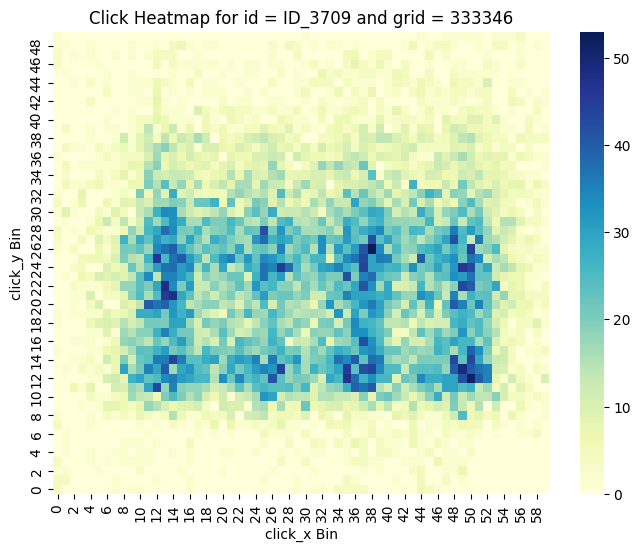

In [29]:
representative_heatmap_6p = {}

for g_id in [333519, 333346]:
    filtered_data = data_metrics_6p[data_metrics_6p.grid_id == g_id]

    result    = filtered_data[(filtered_data.landed_clicks / filtered_data.clicks) > 0.8]
    uniq_doms = result.domain.unique()
    f1 = data_heatmap_6p[(data_heatmap_6p.grid_id==g_id)]
    dom_sorted = f1[f1.domain.isin(uniq_doms)].groupby(['domain']).sum('clicks').sort_values(by='clicks', 
                                                                                             ascending=False)
    dom = dom_sorted.reset_index().iloc[0].domain
    representative_heatmap_6p[g_id] = dom
    
    data_obs = aggregated_clicks_6p[(aggregated_clicks_6p.grid_id == g_id) &
                                 (aggregated_clicks_6p.domain == dom)]
    print(f'Total clicks for (grid_id, domain): ({g_id}, {dom}): {data_obs.clicks_sum.sum()}')
    data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
    #data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
    click_matrix = data_obs.pivot("click_y_bin",
                                      "click_x_bin",
                                      "clicks_sum").fillna(0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(click_matrix, 
                cmap = "YlGnBu", 
                annot = False, 
                cbar = True, 
                fmt = "g")
    plt.title(f'Click Heatmap for id = {dom} and grid = {g_id}')
    plt.xlabel('click_x Bin')
    plt.ylabel('click_y Bin')
    plt.gca().invert_yaxis() 
    plt.show()

In [30]:
data_heatmap_6p[(data_heatmap_6p.grid_id==333346)].groupby(['domain']).sum('clicks').sort_values(by='clicks', 
                                                                                             ascending=False)

,Unnamed: 0,grid_id,click_x,click_y,display_height,display_width,clicks
domain,,,,,,,
ID_3516,176085547398,16285952176,7648508,6109790,12214000,14656800,208944
ID_1220,169149476860,13909861888,6364339,5397037,10432000,12518400,109542
ID_762,115841530327,11152090430,5175136,4181641,8363750,10036500,66326
ID_2883,83035543672,7281943370,3416916,3093539,5461250,6553500,35724
ID_2387,82165179182,6804258552,3194504,2803468,5103000,6123600,31977
...,...,...,...,...,...,...,...
ID_1538,400425900,66669200,33299,27977,50000,60000,200
ID_1353,125096700,66669200,30477,28565,50000,60000,200
ID_1131,52474900,66669200,27207,27372,50000,60000,200


Total clicks for (grid_id, domain): (333519, ID_3516): 262245


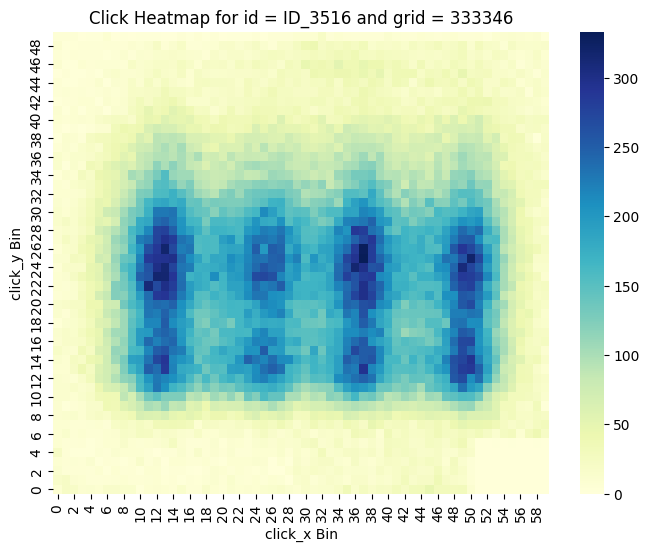

In [31]:
dom = 'ID_3516'
representative_heatmap_6p[333346] = dom
    
data_obs = aggregated_clicks_6p[(aggregated_clicks_6p.grid_id == g_id) &
                             (aggregated_clicks_6p.domain == dom)]
print(f'Total clicks for (grid_id, domain): (333519, {dom}): {data_obs.clicks_sum.sum()}')
data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
# data_obs_enh = enhance_data(data_obs, 'proba', 200000, 0)
click_matrix = data_obs.pivot("click_y_bin",
                                  "click_x_bin",
                                  "clicks_sum").fillna(0)
plt.figure(figsize=(8, 6))
sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")
plt.title(f'Click Heatmap for id = {dom} and grid = {333346}')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
plt.show()

In [32]:
domains_by_grid_id_6p = pd.DataFrame(aggregated_clicks_6p.groupby('grid_id')['domain'].unique()).reset_index()

In [33]:
data_bad = pd.DataFrame(list(product(range(0,60),range(0,50))), 
                                          columns=['click_x_bin', 'click_y_bin'])
data_bad['proba'] = 1/data_bad.shape[0]

Total clicks for (grid_id, domain): (333519, ID_1501): 196561


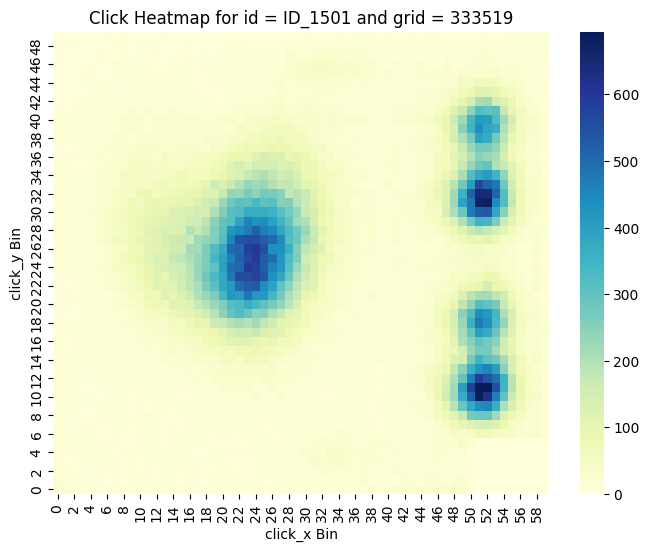

Total clicks for (grid_id, domain): (333346, ID_248): 95385


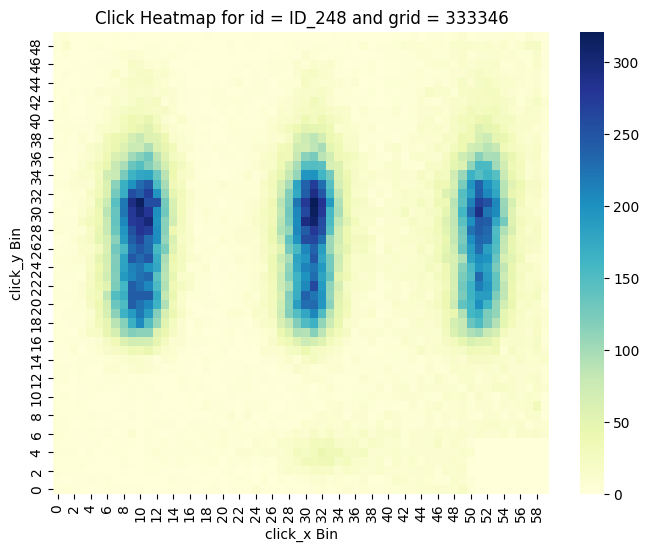

In [34]:
representative_heatmap = {}

for g_id in [333519, 333346]:
    filtered_data = data_metrics[data_metrics.grid_id == g_id]

    result    = filtered_data[(filtered_data.landed_clicks / filtered_data.clicks) > 0.8]
    uniq_doms = result.domain.unique()
    f1 = data_heatmap[(data_heatmap.grid_id==g_id)]
    dom_sorted = f1[f1.domain.isin(uniq_doms)].groupby(['domain']).sum('clicks').sort_values(by='clicks', 
                                                                                             ascending=False)
    dom = dom_sorted.reset_index().iloc[0].domain
    representative_heatmap[g_id] = dom
    
    data_obs = aggregated_clicks[(aggregated_clicks.grid_id == g_id) &
                                 (aggregated_clicks.domain == dom)]
    print(f'Total clicks for (grid_id, domain): ({g_id}, {dom}): {data_obs.clicks_sum.sum()}')
    data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
    #data_obs_enh = enhance_data(data_obs, 'proba', 10000, 1.5)
    click_matrix = data_obs.pivot("click_y_bin",
                                      "click_x_bin",
                                      "clicks_sum").fillna(0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(click_matrix, 
                cmap = "YlGnBu", 
                annot = False, 
                cbar = True, 
                fmt = "g")
    plt.title(f'Click Heatmap for id = {dom} and grid = {g_id}')
    plt.xlabel('click_x Bin')
    plt.ylabel('click_y Bin')
    plt.gca().invert_yaxis() 
    plt.show()

In [36]:
#TODO: fix for train/test on 6p
# Run gridsearch for LRT:

# avoid dividing by 0:
eps = 1e-20

# keep track of misidentified:
misid = {}
misid1 = {}

stdev_values = [0]
size_values = [5000]
proba_thres_values = [0.1]

# Representative heatmap domain_ids
representative_heatmap_train = representative_heatmap_6p
# Dataset to take the representative heatmap from
aggregated_clicks_train = aggregated_clicks_6p
# Dataset to classify
aggregated_clicks_test = aggregated_clicks_6p
# List of domains to classify (by grid ID)
domains_by_grid_id_test = domains_by_grid_id_6p

for stdev in stdev_values:
    for size in size_values:
        for proba_thres in proba_thres_values:

            misid = {'FN': [], 'FP': [], 'TN': [], 'TP': []}
            # misid[(stdev,size,proba_thres)] = {'FN': [], 'FP': []}
            TP, TN, FP, FN = 0, 0, 0, 0
            
            misid1[(stdev,size,proba_thres)] = {'FN': [], 'FP': []}
            TP1, TN1, FP1, FN1 = 0, 0, 0, 0

            for g_id in [333519]:# [333519, 333346]:

                # data = repr clicks for grid_id = g_id (in principle should probably do some train/test split):
                data = pd.DataFrame(list(product(range(0,60),range(0,50))), 
                                          columns=['click_x_bin', 'click_y_bin'])
                
                # data = aggregated_clicks_by_grid_6p[aggregated_clicks_by_grid_6p.grid_id == g_id]

                # compute probability by bin
                # data['proba'] = data['clicks_sum']/data['clicks_sum'].sum()
                
                # representative probabilities:
                data_obs_rep = aggregated_clicks_train[(aggregated_clicks_train.grid_id == g_id) &
                                                 (aggregated_clicks_train.domain == representative_heatmap_train[g_id])]

                # merge enhanced observed heatmap with empirical distribution
                # in order to get empircal probabilities for bins:
                data_obs_rep = data_obs_rep.merge(data, 
                                              on=['click_x_bin','click_y_bin'], 
                                              how='right').fillna(0)
                
                data_obs_rep['proba'] = data_obs_rep.clicks_sum/data_obs_rep.clicks_sum.sum()

                data = data.merge(data_obs_rep[['click_x_bin','click_y_bin','proba']], 
                                  on = ['click_x_bin','click_y_bin'], 
                                  how='left' )
                
                data = data.fillna(0)

                '''
                compute probability for "average" heatmap based on bootstrap sampling of data. 

                The empirical distribution is given by the proba columns and we bootstrap
                sample based on that column as well as evaluate the log-probability.

                The bootstrapped sample is of size = size (notice that the size should be 
                the same as the size for the instance-heatmap to get "fair" comparison, if not
                we would have to normalize accordingly).

                n_bootstrap = number of generated heatmaps to compute average.

                The following returns the avg log-probability:
                '''
                avg_from_empirical = weighted_bootstrap_resample(data, 
                                                                 'proba', 
                                                                 'proba', 
                                                                 size, 
                                                                 n_bootstraps=1000)


                # run over domains, dom for given grid_id = g_id:
                for dom in domains_by_grid_id_test[domains_by_grid_id_test.grid_id == g_id]['domain'].iloc[0]:

                    ####################
                    # chi-squared method:
                    # returns p-value for chi-squared comparison of heatmap vs empirical distribution
#                     _, pv, tot_obs = Chi_squared_test_enh(aggregated_clicks_6p, 
#                                                           aggregated_clicks_by_grid_6p, 
#                                                           dom, g_id, size, .5)

                    ####################
                    # log-probability method:

                    # data_obs = "observed" heatmap for current domain_id = dom
                    data_obs = aggregated_clicks_test[(aggregated_clicks_test.grid_id == g_id) &
                                                 (aggregated_clicks_test.domain == dom)]

                    # add proba column in order to do bootstrap enhancement:
                    data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()

                    # enhanced observed heatmap of size = size, with stdev = stdev 
                    # and sampling based on proba column:
                    data_obs_enh = enhance_data(data_obs, 'proba', size, stdev)

                    # merge enhanced observed heatmap with empirical distribution
                    # in order to get empircal probabilities for bins:
                    data_obs = data_obs_enh.merge(data, 
                                                  on=['click_x_bin','click_y_bin'], 
                                                  how='right').fillna(0)

                    # log-probablity for enhanced oberved heatmap given the underlying empirical distribution:
                    from_obs = (np.log(data_obs['proba']+eps)*data_obs['clicks_sum']).sum()

                    # compare with average heatmap from empirical distribution:
                    # prob = P[distr for domain]/P[avg distr]
                    prob = np.exp(from_obs - avg_from_empirical)
                    log_prob = from_obs - avg_from_empirical

                    ####################
                    # "lrt" method:

                    data_obs_bad = data_obs_enh.merge(data_bad, 
                                                  on=['click_x_bin','click_y_bin'], 
                                                  how='right').fillna(0)

                    from_obs_bad = (np.log(data_obs_bad['proba']+eps)*data_obs_bad['clicks_sum']).sum()

                    loglrt = from_obs - from_obs_bad

                    if loglrt < np.log(proba_thres): # banner classified as 1 (broken)
                        if dom in cb[g_id]:
                            TP += 1
                            misid['TP'].append(dom)                            
                        else:
                            FP += 1
                            misid['FP'].append(dom)
                    else:
                        if dom in cb[g_id]:
                            FN += 1
                            misid['FN'].append(dom)
                        else:
                            TN += 1
                            misid['TN'].append(dom)
                            
                            
                    if log_prob < np.log(proba_thres):
                        if dom in cb[g_id]:
                            TP1 += 1
                        else:
                            FP1 += 1
                            misid1[(stdev,size,proba_thres)]['FP'].append(dom)
                    else:
                        if dom in cb[g_id]:
                            FN1 += 1
                            misid1[(stdev,size,proba_thres)]['FN'].append(dom)
                        else:
                            TN1 += 1

            print(f'Standard dev: {stdev}')
            print(f'Upsample size: {size}')
            print(f'Probability thresh: {proba_thres}')
            print(f'Confusion matrix (lrt): ((TN,FN),(FP,TP)) = ({TN},{FN}),({FP},{TP})')
            if TP+FP != 0 and TP+FN !=0:
                prec = TP/(TP+FP)
                recall = TP/(TP+FN)
                F1 = 2*prec*recall/(prec+recall)
                print(f'F1-score: {F1:.5f}')
            
            print(f'Confusion matrix (old): ((TN,FN),(FP,TP)) = ({TN1},{FN1}),({FP1},{TP1})')
            print('-----------------------------------------------------------')
            

Standard dev: 0
Upsample size: 5000
Probability thresh: 0.1
Confusion matrix (lrt): ((TN,FN),(FP,TP)) = (1925,26),(109,1)
F1-score: 0.01460
Confusion matrix (old): ((TN,FN),(FP,TP)) = (141,0),(1893,27)
-----------------------------------------------------------


Stop here

In [ ]:
def plot_heatmap(g_id, domain_id, upsample_to, aggregated_clicks):
    data_obs = aggregated_clicks[(aggregated_clicks.grid_id == g_id) &
                                 (aggregated_clicks.domain == domain_id)]
    print(f'Total clicks for (grid_id, domain): ({g_id}, {domain_id}): {data_obs.clicks_sum.sum()}')
    data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()
    if upsample_to != 0:
        data_obs = enhance_data(data_obs, 'proba', upsample_to, 0)
    click_matrix = data_obs.pivot("click_y_bin",
                                      "click_x_bin",
                                      "clicks_sum").fillna(0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(click_matrix, 
                cmap = "YlGnBu", 
                annot = False, 
                cbar = True, 
                fmt = "g")
    plt.title(f'Click Heatmap for id = {domain_id} and grid = {g_id}')
    plt.xlabel('click_x Bin')
    plt.ylabel('click_y Bin')
    plt.gca().invert_yaxis() 
    plt.show()

In [ ]:
# # train on 6p
# # Run gridsearch for LRT:

# # upsampling size:
# # size = 1000

# # avoid dividing by 0:
# eps = 1e-20

# # stdev for noisy bootstrap enhancement:
# # stdev = 0

# # keep track of misidentified:
# misid = {}
# misid1 = {}

# # p-value threshold for chi-squared test:
# # pv_thresh = 0.0000001

# # probability threshold:
# # proba_thres = 0.0000001

# for stdev in [0, 1, 2]:
#     for size in [1000, 5000, 10000]:
#         for proba_thres in [0.1, 0.001, 0.00001, 0.0000001]:

#             misid[(stdev,size,proba_thres)] = {'FN': [], 'FP': []}
#             TP, TN, FP, FN = 0, 0, 0, 0
            
#             misid1[(stdev,size,proba_thres)] = {'FN': [], 'FP': []}
#             TP1, TN1, FP1, FN1 = 0, 0, 0, 0

#             for g_id in [333346]:# [333519, 333346]:

#                 # data = repr clicks for grid_id = g_id (in principle should probably do some train/test split):
#                 data = pd.DataFrame(list(product(range(0,60),range(0,50))), 
#                                           columns=['click_x_bin', 'click_y_bin'])
                
#                 # data = aggregated_clicks_by_grid_6p[aggregated_clicks_by_grid_6p.grid_id == g_id]

#                 # compute probability by bin
#                 # data['proba'] = data['clicks_sum']/data['clicks_sum'].sum()
                
#                 # representative probabilities:
#                 data_obs_rep = aggregated_clicks_6p[(aggregated_clicks_6p.grid_id == g_id) &
#                                                  (aggregated_clicks_6p.domain == representative_heatmap[g_id])]

#                 # merge enhanced observed heatmap with empirical distribution
#                 # in order to get empircal probabilities for bins:
#                 data_obs_rep = data_obs_rep.merge(data, 
#                                               on=['click_x_bin','click_y_bin'], 
#                                               how='right').fillna(0)
                
#                 data_obs_rep['proba'] = data_obs_rep.clicks_sum/data_obs_rep.clicks_sum.sum()

#                 data = data.merge(data_obs_rep[['click_x_bin','click_y_bin','proba']], 
#                                   on = ['click_x_bin','click_y_bin'], 
#                                   how='left' )
                
#                 data = data.fillna(0)

#                 '''
#                 compute probability for "average" heatmap based on bootstrap sampling of data. 

#                 The empirical distribution is given by the proba columns and we bootstrap
#                 sample based on that column as well as evaluate the log-probability.

#                 The bootstrapped sample is of size = size (notice that the size should be 
#                 the same as the size for the instance-heatmap to get "fair" comparison, if not
#                 we would have to normalize accordingly).

#                 n_bootstrap = number of generated heatmaps to compute average.

#                 The following returns the avg log-probability:
#                 '''
#                 avg_from_empirical = weighted_bootstrap_resample(data, 
#                                                                  'proba', 
#                                                                  'proba', 
#                                                                  size, 
#                                                                  n_bootstraps=1000)


#                 # run over domains, dom for given grid_id = g_id:
#                 for dom in domains_by_grid_id_6p[domains_by_grid_id_6p.grid_id == g_id]['domain'].iloc[0]:

#                     ####################
#                     # chi-squared method:
#                     # returns p-value for chi-squared comparison of heatmap vs empirical distribution
# #                     _, pv, tot_obs = Chi_squared_test_enh(aggregated_clicks_6p, 
# #                                                           aggregated_clicks_by_grid_6p, 
# #                                                           dom, g_id, size, .5)

#                     ####################
#                     # log-probability method:

#                     # data_obs = "observed" heatmap for current domain_id = dom
#                     data_obs = aggregated_clicks_6p[(aggregated_clicks_6p.grid_id == g_id) &
#                                                  (aggregated_clicks_6p.domain == dom)]

#                     # add proba column in order to do bootstrap enhancement:
#                     data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()

#                     # enhanced observed heatmap of size = size, with stdev = stdev 
#                     # and sampling based on proba column:
#                     data_obs_enh = enhance_data(data_obs, 'proba', size, stdev)

#                     # merge enhanced observed heatmap with empirical distribution
#                     # in order to get empircal probabilities for bins:
#                     data_obs = data_obs_enh.merge(data, 
#                                                   on=['click_x_bin','click_y_bin'], 
#                                                   how='right').fillna(0)

#                     # log-probablity for enhanced oberved heatmap given the underlying empirical distribution:
#                     from_obs = (np.log(data_obs['proba']+eps)*data_obs['clicks_sum']).sum()

#                     # compare with average heatmap from empirical distribution:
#                     # prob = P[distr for domain]/P[avg distr]
#                     prob = np.exp(from_obs - avg_from_empirical)
#                     log_prob = from_obs - avg_from_empirical

#                     ####################
#                     # "lrt" method:

#                     data_obs_bad = data_obs_enh.merge(data_bad, 
#                                                   on=['click_x_bin','click_y_bin'], 
#                                                   how='right').fillna(0)

#                     from_obs_bad = (np.log(data_obs_bad['proba']+eps)*data_obs_bad['clicks_sum']).sum()

#                     loglrt = from_obs - from_obs_bad

#                     if loglrt < np.log(proba_thres):
#                         if dom in cb_6p[g_id]:
#                             TP += 1
#                         else:
#                             FP += 1
#                             misid[(stdev,size,proba_thres)]['FP'].append(dom)
#                     else:
#                         if dom in cb_6p[g_id]:
#                             FN += 1
#                             misid[(stdev,size,proba_thres)]['FN'].append(dom)
#                         else:
#                             TN += 1
                            
                            
#                     if log_prob < np.log(proba_thres):
#                         if dom in cb_6p[g_id]:
#                             TP1 += 1
#                         else:
#                             FP1 += 1
#                             misid1[(stdev,size,proba_thres)]['FP'].append(dom)
#                     else:
#                         if dom in cb_6p[g_id]:
#                             FN1 += 1
#                             misid1[(stdev,size,proba_thres)]['FN'].append(dom)
#                         else:
#                             TN1 += 1

#             print(f'Standard dev: {stdev}')
#             print(f'Upsample size: {size}')
#             print(f'Probability thresh: {proba_thres}')
#             print(f'Confusion matrix (lrt): ((TN,FN),(FP,TP)) = ({TN},{FN}),({FP},{TP})')
#             if TP+FP != 0 and TP+FN !=0:
#                 prec = TP/(TP+FP)
#                 recall = TP/(TP+FN)
#                 F1 = 2*prec*recall/(prec+recall)
#                 print(f'F1-score: {F1:.5f}')
            
#             print(f'Confusion matrix (old): ((TN,FN),(FP,TP)) = ({TN1},{FN1}),({FP1},{TP1})')
#             print('-----------------------------------------------------------')
            

-----

# Old methods

## Cluster

To do -> use previous click clustering method based on representative sample (1-shot) and calculate fraction of points in cluster vs not in cluster

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [ ]:
representative_enh = enhance_data(data, 'proba', 1000000, 0)
click_matrix = representative_enh.pivot("click_y_bin",
                                  "click_x_bin",
                                  "clicks_sum").fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")
plt.title(f'Click Heatmap for grid = {g_id}')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
plt.show()

In [ ]:
# def enhance_data_with_noise(data, prob, size, sdev):
#     indices = np.random.choice(data.index,
#                                    size,
#                                    replace = True,
#                                    p = data[prob])

#     pert_x = np.random.normal(0, sdev, size).round().astype(int)
#     pert_y = np.random.normal(0, sdev, size).round().astype(int)

#     x = data.loc[indices][['click_x_bin', 'click_y_bin']] + np.array((pert_x, pert_y)).reshape(-1,2)
#     x_bin_max = data['click_x_bin'].max()
#     y_bin_max = data['click_y_bin'].max()

#     x.loc[x['click_x_bin'] < 0, 'click_x_bin'] = 0
#     x.loc[x['click_y_bin'] < 0, 'click_y_bin'] = 0
#     x.loc[x['click_x_bin'] > x_bin_max, 'click_x_bin'] = x_bin_max
#     x.loc[x['click_y_bin'] > y_bin_max, 'click_y_bin'] = y_bin_max

#     x = x.groupby(['click_x_bin','click_y_bin']).size().reset_index(name = 'clicks_sum')

#     tt = pd.DataFrame(list(product(range(0,x_bin_max+1), range(0,y_bin_max+1))),
#                       columns=['click_x_bin', 'click_y_bin'])

#     data_obs_merged = tt.merge(x, on = ['click_x_bin','click_y_bin'], how = 'left').fillna(0)
# #    data_obs_merged['boots_clicks'].sum()
#     return data_obs_merged

In [ ]:
def enhance_data_with_noise_pixels(data, prob, size, sdev):
    indices = np.random.choice(data.index, 
                                   size, 
                                   replace=True, 
                                   p = data[prob])
    
    pert_x = np.random.normal(0, sdev, size).round().astype(int)
    pert_y = np.random.normal(0, sdev, size).round().astype(int)

    x = data.loc[indices][['click_x', 'click_y']] + np.array((pert_x, pert_y)).reshape(-1,2)
    x_bin_max = data['display_width'].max()
    y_bin_max = data['display_height'].max()
    
    x.loc[x['click_x'] < 0, 'click_x_bin'] = 0
    x.loc[x['click_y'] < 0, 'click_y_bin'] = 0
    x.loc[x['click_x'] > x_bin_max, 'click_x_bin'] = x_bin_max
    x.loc[x['click_y'] > y_bin_max, 'click_y_bin'] = y_bin_max

    x = x.groupby(['click_x','click_y']).size().reset_index(name = 'clicks_sum')

    tt = pd.DataFrame(list(product(range(0,x_bin_max+1), range(0,y_bin_max+1))),
                      columns=['click_x', 'click_y'])

    data_obs_merged = tt.merge(x, on = ['click_x','click_y'], how = 'left').fillna(0)
#    data_obs_merged['boots_clicks'].sum()
    return data_obs_merged

In [ ]:
# fixed params:
NR_OF_SAMPLES_REP = 100000
STDEV_REP         = 0
NR_OF_SAMPLES     = 5000
STDEV             = 10
MIN_SAMPLES       = 1000

# grid search params:
NR_OF_THRESH_ = 10
eps_choice = np.linspace(0.1,0.2, 8)

# --------------------------------------
# generate representative click samples:
rep_samples = {}
for GRID_ID in [333346,333519]:
    ex_agg = data_heatmap[(data_heatmap.grid_id == GRID_ID) &
                         (data_heatmap.domain == representative_heatmap[GRID_ID])
                         ].groupby(['click_x','click_y'], as_index=False)['clicks'].sum()
    ex_agg['proba']          = ex_agg['clicks']/ex_agg['clicks'].sum()
    ex_agg['display_height'] = data_heatmap['display_height'].max()
    ex_agg['display_width']  = data_heatmap['display_width'].max()
    ex_agg_ = enhance_data_with_noise_pixels(ex_agg, 'proba', NR_OF_SAMPLES_REP, STDEV_REP)
    rep_samples[GRID_ID] = ex_agg_.loc[
        ex_agg_.index.repeat(ex_agg_['clicks_sum'])
                    ].reset_index(drop=True)[['click_x','click_y']]
    
# --------------------------------------

for epsilon in eps_choice:

    print('\n')
    print('----------------------------------------')
    print(f'Epsilon: {epsilon:.2f}')
    
    for GRID_ID in [333346,333519]: 

        print(f'grid id: {GRID_ID}')

        # generate DBSCAN Cluster ---------------------

        ex = rep_samples[GRID_ID].copy()
        scaler = StandardScaler()
        ex_ = scaler.fit_transform(ex)
        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(ex_)
        db = DBSCAN(eps = epsilon, min_samples = MIN_SAMPLES).fit(ex_)

        labels        = db.labels_
        n_clusters_   = len(set(labels)) - (1 if -1 in labels else 0)
        ex['cluster'] = labels

        # remove "bad clusters":
        bad_clusters = [-1]
        for l in unique_labels:
            # more than 90% below threshold:
            if (ex[ex.cluster==l].click_y < 20).sum()/ex[ex.cluster==l].click_y.count() > 0.9:
                bad_clusters.append(l)

        n_noise_      = sum([list(labels).count(bc) for bc in bad_clusters])
        pct_noise_    = (n_noise_/labels.shape[0])

        print("Estimated number of clusters:     %d" % n_clusters_)
        print("Estimated number of noise points: %d" % n_noise_)
        print("Pct of noise points:              %f" % pct_noise_)

        # draw picture: --------------
        plt.figure(figsize=(10, 6))
        unique_labels = set(labels)
        for label in unique_labels:
            if label == -1: # noise
                color = 'k' 
            else:
                color = plt.cm.Spectral(float(label) / len(unique_labels))
            cluster_data = ex[ex['cluster'] == label]
            plt.scatter(cluster_data['click_x'], 
                        cluster_data['click_y'], 
                        s=5, 
                        c=[color], 
                        label=f'Cluster {label}' if label != -1 else 'Noise')

        plt.title('Clusters identified by DBSCAN')
        plt.xlabel('click_x')
        plt.ylabel('click_y')
        plt.legend()
        plt.show()
        # ----------------------------

        if n_clusters_ < 3:
            print('Not enough clusteres.')
            break

        p_bulk_noise = pct_noise_
        p_bulk_success = 1- p_bulk_noise
        
        PCT_THRES = np.linspace(pct_noise_, 0.9, NR_OF_THRESH_)
        
        TP = {i:0 for i, pct_thres in enumerate(PCT_THRES)}
        TN = {i:0 for i, pct_thres in enumerate(PCT_THRES)}
        FP = {i:0 for i, pct_thres in enumerate(PCT_THRES)}
        FN = {i:0 for i, pct_thres in enumerate(PCT_THRES)}

        for ID in data_heatmap[(data_heatmap.grid_id == GRID_ID)].domain.unique():

            # get data for domain:
            data_obs = data_heatmap[(data_heatmap.grid_id == GRID_ID) &
                                     (data_heatmap.domain == ID)]
            data_obs['proba'] = data_obs['clicks']/data_obs['clicks'].sum()

            # data enhancement:
            data_obs_enh = enhance_data_with_noise_pixels(data_obs, 'proba', NR_OF_SAMPLES, STDEV)

            # standardize:
            test = data_obs_enh.loc[data_obs_enh.index.repeat(data_obs_enh['clicks_sum'])].reset_index(
                drop=True)
            test = test[['click_x','click_y']]

            # KNN:
            test_ = scaler.transform(test)
            distances, indices = nn.kneighbors(test_)

            # attach labels:
            predicted_labels = labels[indices.flatten()]
            test['predicted_cluster'] = predicted_labels

            # Get noise pct for domain:
            test_noise_pct = test[(test.predicted_cluster).isin(bad_clusters)].shape[0]/test.shape[0]
            test_success_pct = 1 - test_noise_pct

            # binomial hypo test (not necessary with click upsampling):
#                 bt = binomtest(test[~(test.predicted_cluster.isin(bad_clusters))].shape[0], 
#                                n = test.shape[0], 
#                                p = p_bulk_success, 
#                                alternative='less')

            for i, pct_thres in enumerate(PCT_THRES):
                if test_noise_pct > pct_thres:
                    if ID in cb[g_id]:
                        TP[i] += 1
                    else:
                        FP[i] += 1
                else:
                    if ID in cb[g_id]:
                        FN[i] += 1
                    else:
                        TN[i] += 1
        
        for i, pct_thres in enumerate(PCT_THRES):
            print('----------------------------------------')
            print(f'Pct Threshold: {pct_thres:.2f}')
            if TP[i]+FP[i] != 0 and TP[i]+FN[i] !=0:
                TP1, TN1, FP1, FN1 = TP[i], TN[i], FP[i], FN[i]
                
                print(f'Confusion matrix: ((TN,FN),(FP,TP)) = ({TN1},{FN1}),({FP1},{TP1})')
                prec = TP1/(TP1+FP1)
                recall = TP1/(TP1+FN1)
                F1 = 2*prec*recall/(prec+recall)
                print(f'F1-score: {F1:.5f}')

In [ ]:
# # fixed params:
# NR_OF_SAMPLES_REP = 100000
# STDEV_REP         = 10
# NR_OF_SAMPLES     = 5000
# STDEV             = 10
# MIN_SAMPLES       = 1000

# # grid search params:
# NR_OF_THRESH_ = 5
# eps_choice = np.linspace(0.1,0.4, 21)

# # --------------------------------------
# # generate representative click samples:
# rep_samples = {}
# for GRID_ID in [333519, 333346]:
#     ex_agg = data_heatmap[(data_heatmap.grid_id == GRID_ID) &
#                          (data_heatmap.domain == representative_heatmap[GRID_ID])
#                          ].groupby(['click_x','click_y'], as_index=False)['clicks'].sum()
#     ex_agg['proba']          = ex_agg['clicks']/ex_agg['clicks'].sum()
#     ex_agg['display_height'] = data_heatmap['display_height'].max()
#     ex_agg['display_width']  = data_heatmap['display_width'].max()
#     ex_agg_ = enhance_data_with_noise_pixels(ex_agg, 'proba', NR_OF_SAMPLES_REP, STDEV_REP)
#     rep_samples[GRID_ID] = ex_agg_.loc[
#         ex_agg_.index.repeat(ex_agg_['clicks_sum'])
#                     ].reset_index(drop=True)[['click_x','click_y']]
    
# # --------------------------------------

# for epsilon in eps_choice:

#     print('\n')
#     print('----------------------------------------')
#     print(f'Epsilon: {epsilon:.2f}')
    
#     for pct_thres in np.linspace(0.4, 0.9, NR_OF_THRESH_):
#         print('----------------------------------------')
#         print(f'Pct Threshold: {pct_thres:.2f}')

#         misid[(pct_thres,epsilon)] = {'FN': [], 'FP': []}
#         TP, TN, FP, FN = 0, 0, 0, 0

#         for GRID_ID in [333519, 333346]: 
            
#             print(f'grid id: {GRID_ID}')

#             # generate DBSCAN Cluster ---------------------
            
#             ex = rep_samples[GRID_ID].copy()
#             scaler = StandardScaler()
#             ex_ = scaler.fit_transform(ex)
#             nn = NearestNeighbors(n_neighbors=1)
#             nn.fit(ex_)
#             db = DBSCAN(eps = epsilon, min_samples = MIN_SAMPLES).fit(ex_)

#             labels        = db.labels_
#             n_clusters_   = len(set(labels)) - (1 if -1 in labels else 0)
#             ex['cluster'] = labels

#             # remove "bad clusters":
#             bad_clusters = [-1]
#             for l in unique_labels:
#                 # more than 90% below threshold:
#                 if (ex[ex.cluster==l].click_y < 20).sum()/ex[ex.cluster==l].click_y.count() > 0.9:
#                     bad_clusters.append(l)

#             n_noise_      = sum([list(labels).count(bc) for bc in bad_clusters])
#             pct_noise_    = (n_noise_/labels.shape[0])
            
#             print("Estimated number of clusters:     %d" % n_clusters_)
#             print("Estimated number of noise points: %d" % n_noise_)
#             print("Pct of noise points:              %f" % pct_noise_)

#             # draw picture: --------------
#             plt.figure(figsize=(10, 6))
#             unique_labels = set(labels)
#             for label in unique_labels:
#                 if label == -1: # noise
#                     color = 'k' 
#                 else:
#                     color = plt.cm.Spectral(float(label) / len(unique_labels))
#                 cluster_data = ex[ex['cluster'] == label]
#                 plt.scatter(cluster_data['click_x'], 
#                             cluster_data['click_y'], 
#                             s=5, 
#                             c=[color], 
#                             label=f'Cluster {label}' if label != -1 else 'Noise')

#             plt.title('Clusters identified by DBSCAN')
#             plt.xlabel('click_x')
#             plt.ylabel('click_y')
#             plt.legend()
#             plt.show()
#             # ----------------------------

#             if n_clusters_ < 3:
#                 print('Not enough clusteres.')
#                 break
            
#             p_bulk_noise = pct_noise_
#             p_bulk_success = 1- p_bulk_noise

#             for ID in data_heatmap[(data_heatmap.grid_id == GRID_ID)].domain.unique():
                
#                 # get data for domain:
#                 data_obs = data_heatmap[(data_heatmap.grid_id == GRID_ID) &
#                                          (data_heatmap.domain == ID)]
#                 data_obs['proba'] = data_obs['clicks']/data_obs['clicks'].sum()
                
#                 # data enhancement:
#                 data_obs_enh = enhance_data_with_noise_pixels(data_obs, 'proba', NR_OF_SAMPLES, STDEV)
                
#                 # standardize:
#                 test = data_obs_enh.loc[data_obs_enh.index.repeat(data_obs_enh['clicks_sum'])].reset_index(
#                     drop=True)
#                 test = test[['click_x','click_y']]

#                 # KNN:
#                 test_ = scaler.transform(test)
#                 distances, indices = nn.kneighbors(test_)
                
#                 # attach labels:
#                 predicted_labels = labels[indices.flatten()]
#                 test['predicted_cluster'] = predicted_labels
                
#                 # Get noise pct for domain:
#                 test_noise_pct = test[(test.predicted_cluster).isin(bad_clusters)].shape[0]/test.shape[0]
#                 test_success_pct = 1 - test_noise_pct

#                 # binomial hypo test (not necessary with click upsampling):
# #                 bt = binomtest(test[~(test.predicted_cluster.isin(bad_clusters))].shape[0], 
# #                                n = test.shape[0], 
# #                                p = p_bulk_success, 
# #                                alternative='less')


#                 if test_noise_pct > pct_thres:
#                     if ID in cb[g_id]:
#                         TP += 1
#                     else:
#                         FP += 1
#                         misid[(pct_thres,epsilon)]['FP'].append(dom)
#                 else:
#                     if ID in cb[g_id]:
#                         FN += 1
#                         misid[(pct_thres,epsilon)]['FN'].append(dom)
#                     else:
#                         TN += 1
        
#         if TP+FP != 0 and TP+FN !=0:
#             print(f'Confusion matrix: ((TN,FN),(FP,TP)) = ({TN},{FN}),({FP},{TP})')
#             prec = TP/(TP+FP)
#             recall = TP/(TP+FN)
#             F1 = 2*prec*recall/(prec+recall)
#             print(f'F1-score: {F1:.5f}')

### New data

In [ ]:
# representative_heatmap_6p

In [ ]:
# fixed params:
NR_OF_SAMPLES_REP = 2*100000
STDEV_REP         = 0
NR_OF_SAMPLES     = 5000
STDEV             = 10
MIN_SAMPLES       = 1000

# grid search params:
NR_OF_THRESH_ = 10
eps_choice = np.linspace(0.12,0.2, 8)

# --------------------------------------
# generate representative click samples:
rep_samples = {}
for GRID_ID in [333346]:
    ex_agg = data_heatmap_6p[(data_heatmap_6p.grid_id == GRID_ID) &
                         (data_heatmap_6p.domain == representative_heatmap[GRID_ID])
                         ].groupby(['click_x','click_y'], as_index=False)['clicks'].sum()
    ex_agg['proba']          = ex_agg['clicks']/ex_agg['clicks'].sum()
    ex_agg['display_height'] = data_heatmap_6p['display_height'].max()
    ex_agg['display_width']  = data_heatmap_6p['display_width'].max()
    ex_agg_ = enhance_data_with_noise_pixels(ex_agg, 'proba', NR_OF_SAMPLES_REP, STDEV_REP)
    rep_samples[GRID_ID] = ex_agg_.loc[
        ex_agg_.index.repeat(ex_agg_['clicks_sum'])
                    ].reset_index(drop=True)[['click_x','click_y']]
    
# --------------------------------------

for epsilon in eps_choice:

    print('\n')
    print('----------------------------------------')
    print(f'Epsilon: {epsilon:.2f}')
    
    for GRID_ID in [333346]: 

        print(f'grid id: {GRID_ID}')

        # generate DBSCAN Cluster ---------------------

        ex = rep_samples[GRID_ID].copy()
        scaler = StandardScaler()
        ex_ = scaler.fit_transform(ex)
        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(ex_)
        db = DBSCAN(eps = epsilon, min_samples = MIN_SAMPLES).fit(ex_)

        labels        = db.labels_
        n_clusters_   = len(set(labels)) - (1 if -1 in labels else 0)
        ex['cluster'] = labels

        # remove "bad clusters":
        bad_clusters = [-1]
        for l in unique_labels:
            # more than 90% below threshold:
            if (ex[ex.cluster==l].click_y < 20).sum()/ex[ex.cluster==l].click_y.count() > 0.9:
                bad_clusters.append(l)

        n_noise_      = sum([list(labels).count(bc) for bc in bad_clusters])
        pct_noise_    = (n_noise_/labels.shape[0])

        print("Estimated number of clusters:     %d" % n_clusters_)
        print("Estimated number of noise points: %d" % n_noise_)
        print("Pct of noise points:              %f" % pct_noise_)

        # draw picture: --------------
        plt.figure(figsize=(10, 6))
        unique_labels = set(labels)
        for label in unique_labels:
            if label == -1: # noise
                color = 'k' 
            else:
                color = plt.cm.Spectral(float(label) / len(unique_labels))
            cluster_data = ex[ex['cluster'] == label]
            plt.scatter(cluster_data['click_x'], 
                        cluster_data['click_y'], 
                        s=5, 
                        c=[color], 
                        label=f'Cluster {label}' if label != -1 else 'Noise')

        plt.title('Clusters identified by DBSCAN')
        plt.xlabel('click_x')
        plt.ylabel('click_y')
        plt.legend()
        plt.show()
        # ----------------------------

        if n_clusters_ < 3:
            print('Not enough clusteres.')
            break

        p_bulk_noise = pct_noise_
        p_bulk_success = 1- p_bulk_noise
        
        PCT_THRES = np.linspace(pct_noise_, 0.9, NR_OF_THRESH_)
        
        TP = {i:0 for i, pct_thres in enumerate(PCT_THRES)}
        TN = {i:0 for i, pct_thres in enumerate(PCT_THRES)}
        FP = {i:0 for i, pct_thres in enumerate(PCT_THRES)}
        FN = {i:0 for i, pct_thres in enumerate(PCT_THRES)}

        for ID in data_heatmap_6p[(data_heatmap_6p.grid_id == GRID_ID)].domain.unique():

            # get data for domain:
            data_obs = data_heatmap_6p[(data_heatmap_6p.grid_id == GRID_ID) &
                                     (data_heatmap_6p.domain == ID)]
            data_obs['proba'] = data_obs['clicks']/data_obs['clicks'].sum()

            # data enhancement:
            data_obs_enh = enhance_data_with_noise_pixels(data_obs, 'proba', NR_OF_SAMPLES, STDEV)

            # standardize:
            test = data_obs_enh.loc[data_obs_enh.index.repeat(data_obs_enh['clicks_sum'])].reset_index(
                drop=True)
            test = test[['click_x','click_y']]

            # KNN:
            test_ = scaler.transform(test)
            distances, indices = nn.kneighbors(test_)

            # attach labels:
            predicted_labels = labels[indices.flatten()]
            test['predicted_cluster'] = predicted_labels

            # Get noise pct for domain:
            test_noise_pct = test[(test.predicted_cluster).isin(bad_clusters)].shape[0]/test.shape[0]
            test_success_pct = 1 - test_noise_pct

            # binomial hypo test (not necessary with click upsampling):
#                 bt = binomtest(test[~(test.predicted_cluster.isin(bad_clusters))].shape[0], 
#                                n = test.shape[0], 
#                                p = p_bulk_success, 
#                                alternative='less')

            for i, pct_thres in enumerate(PCT_THRES):
                if test_noise_pct > pct_thres:
                    if ID in cb_6p[g_id]:
                        TP[i] += 1
                    else:
                        FP[i] += 1
                else:
                    if ID in cb_6p[g_id]:
                        FN[i] += 1
                    else:
                        TN[i] += 1
        
        for i, pct_thres in enumerate(PCT_THRES):
            print('----------------------------------------')
            print(f'Pct Threshold: {pct_thres:.2f}')
            if TP[i]+FP[i] != 0 and TP[i]+FN[i] !=0:
                TP1, TN1, FP1, FN1 = TP[i], TN[i], FP[i], FN[i]
                
                print(f'Confusion matrix: ((TN,FN),(FP,TP)) = ({TN1},{FN1}),({FP1},{TP1})')
                prec = TP1/(TP1+FP1)
                recall = TP1/(TP1+FN1)
                F1 = 2*prec*recall/(prec+recall)
                print(f'F1-score: {F1:.5f}')

## probability

In [ ]:
# upsampling size:
size = 1000

eps = 1e-20

# stdev for noisy bootstrap enhancement:
stdev = 0

# init to count pct of broken banners:
tot_p, tot, tot_pv, tot_lrt = 0, 0, 0, 0

# keep track of misidentified:
misid = {}

# p-value threshold for chi-squared test:
pv_thresh = 0.0000001

# probability threshold:
# proba_thres = 0.0000001

for proba_thres in [0.01, 0.00000001]:
    
    misid[proba_thres] = {'FN': [], 'FP': []}
    TP, TN, FP, FN = 0, 0, 0, 0
    
    for g_id in [333519, 333346]: 

        # data = all clicks for grid_id = g_id (in principle should probably do some train/test split):
        data = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == g_id]

        # compute probability by bin
        data['proba'] = data['clicks_sum']/data['clicks_sum'].sum()

        '''
        compute probability for "average" heatmap based on bootstrap sampling of data. 

        The empirical distribution is given by the proba columns and we bootstrap
        sample based on that column as well as evaluate the log-probability.

        The bootstrapped sample is of size = size (notice that the size should be 
        the same as the size for the instance-heatmap to get "fair" comparison, if not
        we would have to normalize accordingly).

        n_bootstrap = number of generated heatmaps to compute average.

        The following returns the avg log-probability:
        '''
        avg_from_empirical = weighted_bootstrap_resample(data, 
                                                         'proba', 
                                                         'proba', 
                                                         size, 
                                                         n_bootstraps=1000)

        avg_from_empirical_bad = weighted_bootstrap_resample(data_bad, 
                                                         'proba', 
                                                         'proba', 
                                                         size, 
                                                         n_bootstraps=1000)


        # run over domains, dom for given grid_id = g_id:
        for dom in domains_by_grid_id[domains_by_grid_id.grid_id == g_id]['domain'].iloc[0]:
            tot += 1

            ####################
            # chi-squared method:
            # returns p-value for chi-squared comparison of heatmap vs empirical distribution
            _, pv, tot_obs = Chi_squared_test_enh(aggregated_clicks, 
                                                  aggregated_clicks_by_grid, 
                                                  dom, g_id, size, .5)

            ####################
            # log-probability method:

            # data_obs = "observed" heatmap for current domain_id = dom
            data_obs = aggregated_clicks[(aggregated_clicks.grid_id == g_id) &
                                         (aggregated_clicks.domain == dom)]

            # add proba column in order to do bootstrap enhancement:
            data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()

            # enhanced observed heatmap of size = size, with stdev = stdev 
            # and sampling based on proba column:
            data_obs_enh = enhance_data(data_obs, 'proba', size, stdev)

            # merge enhanced observed heatmap with empirical distribution
            # in order to get empircal probabilities for bins:
            data_obs = data_obs_enh.merge(data, 
                                          on=['click_x_bin','click_y_bin'], 
                                          how='right').fillna(0)

            # log-probablity for enhanced oberved heatmap given the underlying empirical distribution:
            from_obs = (np.log(data_obs['proba']+eps)*data_obs['clicks_sum_x']).sum()

            # compare with average heatmap from empirical distribution:
            # prob = P[distr for domain]/P[avg distr]
            prob = np.exp(from_obs - avg_from_empirical)
            log_prob = from_obs - avg_from_empirical

            # if log_prob below certain threshold, label as broken:

            if log_prob < np.log(proba_thres):
                tot_p +=1

            # compare both log-prob and chi-squared p-value:
            if log_prob < np.log(proba_thres) and pv < pv_thresh:
                tot_pv += 1

            ####################
            # "lrt" method:

            data_obs_bad = data_obs_enh.merge(data_bad, 
                                          on=['click_x_bin','click_y_bin'], 
                                          how='right').fillna(0)

            from_obs_bad = (np.log(data_obs_bad['proba']+eps)*data_obs_bad['clicks_sum_x']).sum()

            loglrt = from_obs - from_obs_bad

            if log_prob < np.log(proba_thres):
                tot_lrt += 1
                if dom in cb[g_id]:
                    TP += 1
                else:
                    FP += 1
                    misid[proba_thres]['FP'].append(dom)
            else:
                if dom in cb[g_id]:
                    FN += 1
                    misid[proba_thres]['FN'].append(dom)
                else:
                    TN += 1

    print(f'Probability thresh: {proba_thres}')
    print(f'Confusion matrix: ((TN,FN),(FP,TP)) = ({TN},{FN}),({FP},{TP})')
    print('-----------------------------------------------------------')
            

# Agg broken banners

In [ ]:
data_broken = {}
data_broken_proba = {}

In [ ]:
for g_id in [333519, 333346]:
    agg_broken = aggregated_clicks[(aggregated_clicks.grid_id == g_id) & 
                      (aggregated_clicks.domain.isin(cb[g_id]))]
    
    data_broken[g_id] = agg_broken.groupby([
                                'grid_id','click_x_bin','click_y_bin'
                            ]).sum('clicks_sum').reset_index()
    
    click_matrix = data_broken[g_id].pivot("click_y_bin",
                                      "click_x_bin",
                                      "clicks_sum").fillna(0)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(click_matrix, 
                cmap = "YlGnBu", 
                annot = False, 
                cbar = True, 
                fmt = "g")
    plt.title(f'Click Heatmap for grid = {g_id}')
    plt.xlabel('click_x Bin')
    plt.ylabel('click_y Bin')
    plt.gca().invert_yaxis() 
    plt.show()
    
    
    total_clicks = agg_broken.groupby(['grid_id', 'domain'])['clicks_sum'].transform('sum')
    agg_broken['proba'] = agg_broken['clicks_sum'] / total_clicks
    
    data_broken_proba[g_id] = agg_broken.groupby(['click_x_bin','click_y_bin'
                            ]).sum('proba').reset_index()
    
    data_broken_proba[g_id]['proba1'] = data_broken_proba[g_id]['proba']/data_broken_proba[g_id].proba.sum()
    
    click_matrix = data_broken_proba[g_id].pivot("click_y_bin",
                                      "click_x_bin",
                                      "proba1").fillna(0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(click_matrix, 
                cmap = "YlGnBu", 
                annot = False, 
                cbar = True, 
                fmt = "g")
    plt.title(f'asdf Click Heatmap for grid = {g_id}')
    plt.xlabel('click_x Bin')
    plt.ylabel('click_y Bin')
    plt.gca().invert_yaxis() 
    plt.show()

In [ ]:
asdf = data_broken_proba[333346].drop(columns = ['grid_id']).merge(data_broken_proba[333346].drop(columns = ['grid_id']), on = ['click_x_bin','click_y_bin'], how='outer').fillna(0)
asdf['proba_comb'] = asdf['proba_x']+asdf['proba_y']
asdf['proba_comb'] = asdf['proba_comb']/asdf.proba_comb.sum()

click_matrix = asdf.pivot("click_y_bin",
                                  "click_x_bin",
                                  "proba_comb").fillna(0)
plt.figure(figsize=(8, 6))
sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")
plt.title(f'asdf Click Heatmap for grid = {g_id}')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
plt.show()